# Implemenation of Make Me a BNN


## Import libraries

### Install Missing Packages

In [1]:
!pip install netcal
!pip install torchsummary


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Import Used Libs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torchsummary import summary
from torch.nn.functional import softmax
import torch.nn.functional as F
import netcal.metrics as metrics
from netcal.metrics import ECE
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
from torch.utils.data import random_split
import multiprocessing
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torchvision import datasets

### Import Custom Libs

In [3]:
import sys
# Get the current working directory of the notebook
current_dir = os.path.dirname(os.path.abspath('__file__'))
print(f"current dir is {current_dir}")
# Add the ABNN and 'Simple CNN Demo' directories to the Python path
abnn_dir = os.path.abspath(os.path.join(current_dir, './MakeMe-BNN/ABNN'))
print(f"ABNN dir is {abnn_dir}")
if abnn_dir not in sys.path:
    sys.path.insert(0, abnn_dir)

# Now import the necessary modules
from ABNN.map import CustomMAPLoss
from ABNN.bnl import BNL
from ABNN.datasets.cifar10 import prepare_cifar10_data
from ABNN.datasets.cifar100 import prepare_cifar100_data
from ABNN.datasets.svhn import prepare_svhn_data
from ABNN.deep_learning_models.resnet import ResNet, Bottleneck
from ABNN.test_and_eval import test_model_with_metrics
from ABNN.train import train_model


current dir is /home/abduallah_damash/project/ceng502/MakeMe-BNN
ABNN dir is /home/abduallah_damash/project/ceng502/MakeMe-BNN/MakeMe-BNN/ABNN


### Set the device Usage:

In [4]:
multiprocessing.set_start_method('forkserver', force=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda


##  Dataset

### Load and Augment CIFAR-10 and CIFAR100

Similar to the paper, only used:
- Horizontal Flip for data augmentation.
- Batch size as 128.

#### Load the CIFAR10 dataset

In [5]:
# load all data
trainloader10, validloader10, testloader10 = prepare_cifar10_data()


Files already downloaded and verified
Files already downloaded and verified
CIFAR10 Training set size: 40000
CIFAR10 Validation set size: 10000
CIFAR10 Test set size: 10000


#### Load the CIFAR100 dataset

In [6]:
trainloader100, validloader100, testloader100 = prepare_cifar100_data()

Files already downloaded and verified
Files already downloaded and verified
CIFAR100 Training set size: 40000
CIFAR100 Validation set size: 10000
CIFAR100 Test set size: 10000


#### Load the SVHN dataset

In [7]:
trainloader_svhn, validloader_svhn, testloader_svhn = prepare_svhn_data()


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
SVHN Training set size: 58605
SVHN Validation set size: 14652
SVHN Test set size: 26032


## Define the DL model

### Define ResNen Model

- It can be used as ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
- Added a dropout layer with P=0.3 to prevent overfitting. 

## Define Training and Tesing Loops

### Training Loop:

The `train_model` function is a versatile training loop designed for PyTorch models, providing flexibility in selecting optimizers, loss functions, and various hyperparameters. Here's a brief description of its key features and how it utilizes different parameters:

1. **Optimizer Selection**:
   - The function allows the choice between 'SGD' (Stochastic Gradient Descent) and 'Adam' optimizers via the `Optimizer_type` parameter. This is achieved by checking the value of `Optimizer_type` and initializing the respective optimizer with the specified `learning_rate`, `Weight_decay`, and `Momentum` (for SGD).

2. **Loss Function Selection**:
   - The function supports multiple loss functions, including 'CrossEntropyLoss', 'MSELoss', and a custom loss function 'CustomMAPLoss'. The appropriate loss function is selected based on the `Loss_fn` parameter. For 'CustomMAPLoss', the `Num_classes` and `Weight_decay` parameters are used for initialization.

3. **Learning Rate Scheduler**:
   - A MultiStepLR scheduler is used to adjust the learning rate at specified milestones. The `milestones` parameter defines the epochs at which the learning rate is reduced by a factor specified by `gamma_lr`.

4. **Training and Validation Loop**:
   - The function contains a standard training loop where it iterates over the training dataset, computes the loss, performs backpropagation, and updates the model parameters.
   - After each epoch, the model is evaluated on the validation dataset, and the average validation loss is computed and stored.

5. **Hyperparameters**:
   - Various hyperparameters such as `epochs`, `learning_rate`, `Weight_decay`, `Momentum`, and `Num_classes` can be adjusted to fine-tune the training process according to specific needs.

6. **Model Saving**:
   - The trained model's state dictionary is saved to a specified path (`save_path`) after the training is complete.

7. **Loss Visualization**:
   - The function plots the training and validation losses over epochs for easy visualization of the model's performance.


This design provides flexibility and ease of experimentation with different training configurations, making it suitable for various deep learning tasks.

### Testing Loop:
#### Description:

The `test_model_with_metrics` function evaluates a neural network model on a test dataset, providing flexibility to calculate various performance metrics and uncertainty measures based on the provided flags. This function is designed to offer a comprehensive evaluation with a single loop over the test data, ensuring efficient computation.

#### Functionality:
1. Model Loading: Loads the model state from the specified path and sets the model to evaluation mode.
2. Single Test Loop: Iterates over the test dataset once to compute the required metrics.
4. Uncertainty Calculation: Computes the average uncertainty (variance) for each class if `calculate_uncert` is enabled.
5. Negative Log-Likelihood: Computes and prints the NLL if `calculate_nll_loss` is enabled.
6. Expected Calibration Error: Computes and prints the ECE if `calculate_ece_error` is enabled.
7. Precision-Recall AUC: Computes and prints the mean AUPR if `calculate_auprc` is enabled.
8. ROC AUC: Computes and prints the mean AUC if `calculate_auc_roc` is enabled.
9. FPR at 95% TPR: Computes and prints the mean FPR at 95% TPR if `calculate_fpr_95` is enabled.
10. Parameter Counting: Counts and prints the number of trainable parameters if `count_params` is enabled.
11. Uncertainty Plotting: Plots the uncertainty for different classes if `plot_uncert` is enabled.
12. Ensemble Prediction: Uses an ensemble of models for prediction if `predict_uncert` is enabled, calculating accuracy and variance.

This function ensures a flexible and efficient evaluation of the model, accommodating various metrics and uncertainty assessments as needed.
"""

## Implemantion

### ResNet50 on CIFAR10 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           4,096
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 32, 32]          16,384
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14           [-1, 64,

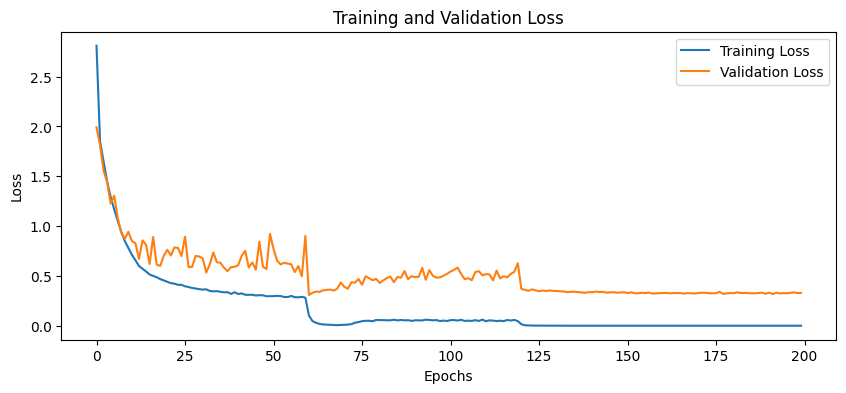

Test set Metrics:
 Average loss: 0.3299 
 F1 Score: 0.9065
Accuracy: 90.67%
Uncertainties: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
ECE: 0.0491
Mean AUPR: 0.9643
Mean AUC: 0.9939
Mean FPR at 95% Recall: 0.0268
Number of Parameters: 23520842


In [18]:
resnet50_cifr10 = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)
resnet50_cifr10.to(device)
summary(resnet50_cifr10, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr10, 
    train_loader=trainloader10, 
    val_loader=validloader10,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr10_dropout.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=10,
    BNL_enable=False,
    BNL_load_path='./resnet50_cifr10_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr10, 
    test_loader=testloader10, 
    load_path="./resnet50_cifr10_dropout.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr10.__class__, 
    models=[torch.load('./resnet50_cifr10_dropout.pth')],
    num_samples=10, 
    num_classes=10
)



### ResNet50 on CIFAR100

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           4,096
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 32, 32]          16,384
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14           [-1, 64,

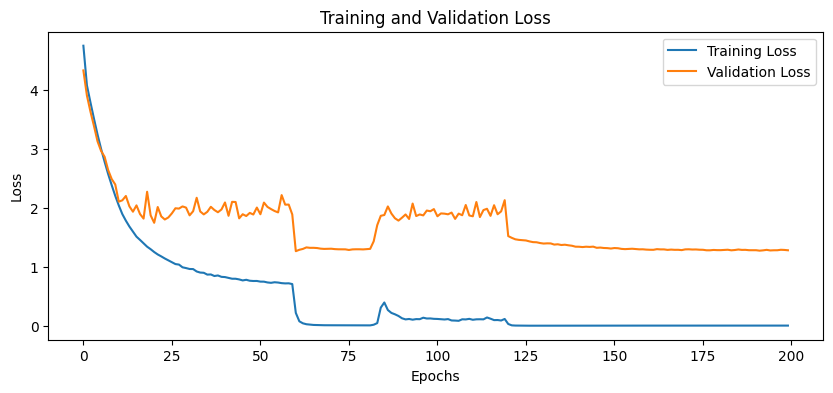

Test set Metrics:
 Average loss: 1.3010 
 F1 Score: 0.6720
Accuracy: 67.47%
Uncertainties: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0}
ECE: 0.0791
Mean A

In [16]:
resnet50_cifr100 = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=100)
resnet50_cifr100.to(device)
summary(resnet50_cifr100, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr100, 
    train_loader=trainloader100, 
    val_loader=validloader100,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr100_dropout.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=100,
    BNL_enable=False,
    BNL_load_path='./resnet50_cifr100_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr100, 
    test_loader=testloader100, 
    load_path="./resnet50_cifr100_dropout.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr100.__class__, 
    models=[torch.load('./resnet50_cifr100_dropout.pth')],
    num_samples=100, 
    num_classes=100
)



### ResNet50 on CIFAR10 with ABNLL

In [8]:
resnet50_cifr10_bnl = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10,norm_layer=BNL)
resnet50_cifr10_bnl.to(device)
#summary(resnet50_cifr10_bnl.to(device), (3, 64, 64))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr10_bnl.to(device), 
    train_loader=trainloader10, 
    val_loader=validloader10,
    epochs=20, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr10_bnl_dropout.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CustomMAPLoss',
    Num_classes=10,
    BNL_enable=True,
    BNL_load_path='./resnet50_cifr10_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn='CustomMAPLoss', 
    model=resnet50_cifr10_bnl, 
    test_loader=testloader10, 
    load_path="./resnet50_cifr10_bnl_dropout.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr10.__class__, 
    models=[torch.load('./resnet50_cifr10_bnl_dropout.pth')],
    num_samples=10, 
    num_classes=10,
    Weight_decay=5e-4
)



BNL model loaded from ./resnet50_cifr10_dropout.pth
Model weights loaded.


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [14]:
resnet50_cifr10_bnl = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10,norm_layer=ABNN.BNL)
resnet50_cifr10_bnl.to(device)
summary(resnet50_cifr10_bnl, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr10_bnl, 
    train_loader=trainloader10, 
    val_loader=validloader10,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr10_bnl_dropout_no_closs.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=10,
    BNL_enable=True,
    BNL_load_path='./resnet50_cifr10_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr10_bnl, 
    test_loader=testloader10, 
    load_path="./resnet50_cifr10_bnl_dropout_no_closs.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr10.__class__, 
    models=[torch.load('./resnet50_cifr10_bnl_dropout_no_closs.pth')],
    num_samples=10, 
    num_classes=10,
    Weight_decay=5e-4
)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
               BNL-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]           4,096
               BNL-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
               BNL-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]          16,384
               BNL-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]          16,384
              BNL-10          [-1, 256, 32, 32]               0
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
              BNL-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

KeyboardInterrupt: 

### ResNet50 on CIFAR100 with ABNLL

In [36]:
resnet50_cifr100_bnl = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=100,norm_layer=ABNN.BNL)
resnet50_cifr100_bnl.to(device)
summary(resnet50_cifr100_bnl, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr100_bnl, 
    train_loader=trainloader100, 
    val_loader=validloader100,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr100_bnl_dropout_no_closs.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=100,
    BNL_enable=True,
    BNL_load_path='./resnet50_cifr100_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr100_bnl, 
    test_loader=testloader100, 
    load_path="./resnet50_cifr100_bnl_dropout_no_closs.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr100_bnl.__class__, 
    models=[torch.load('./resnet50_cifr100_bnl_dropout_no_closs.pth')],
    num_samples=100, 
    num_classes=100,
    Weight_decay=5e-4
)



NameError: name 'ABNN' is not defined